In [2]:
library(dplyr)
library(randomForest)
library(ggplot2)
library(RSNNS)
library(e1071)
library(xgboost)
library(keras)
#library(mice)
library(data.table)
library(caret)
library(lubridate)



options(repr.matrix.max.cols=500, repr.matrix.max.rows=200)
#set.seed(42)

# To try
try implementation by station and train test by station

# 1-Data processing 

[1] 30557    82

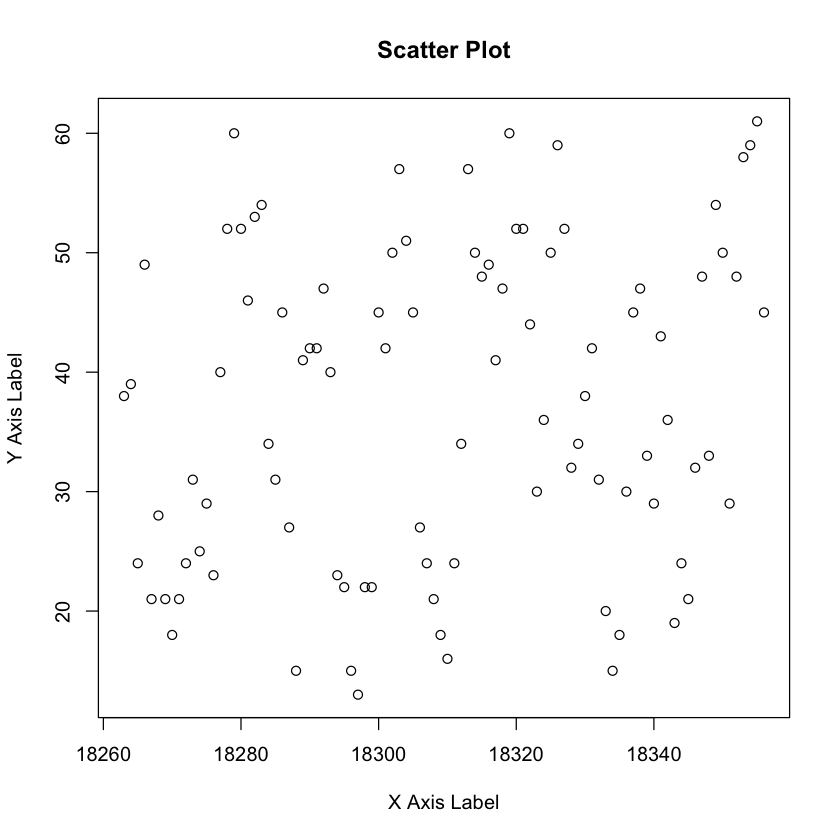

In [7]:
train_df <- read.csv("Data/Train.csv")
dim(train_df)
subsetted_data <- subset(train_df, Place_ID == "010Q650")
subsetted_data$Date <- as.Date(subsetted_data$Date)
subsetted_data$Date <- as.numeric(subsetted_data$Date)

plot(subsetted_data$Date, subsetted_data$target,
     xlab = "X Axis Label",  # Label for the X axis
     ylab = "Y Axis Label",  # Label for the Y axis
     main = "Scatter Plot"   # Title for the plot
)

In [3]:
get_train_data <- function() {
    train_df <- read.csv("Data/Train.csv")
    train_df <- train_df %>% 
        select(-"target_min", -"target_max",-"target_variance",-"target_count",-"Place_ID.X.Date")
    return(train_df)
}

In [4]:
get_test_data <- function() {
    train_df <- read.csv("Data/Test.csv")
    train_df <- train_df %>% 
        select(-"Date")
    return(train_df)
}

# 3-Features selection 

In [5]:
# Drop na's
drop_na <- function(data) {
    data_clean <- data[, colSums(is.na(data)) == 0]
    return(data_clean)
}

# 2-Feature Engineering 

In [6]:
# Replace na's by mean
na_to_mean <- function(data) {
    data_clean <- data %>%
        mutate(across(everything(), ~ifelse(is.na(.), mean(., na.rm = TRUE), .)))
    return(data_clean)
}

In [7]:
# Replace na's by median
na_to_median <- function(data) {
    data_clean <- data %>%
        mutate(across(everything(), ~ifelse(is.na(.), median(., na.rm = TRUE), .)))
    return(data_clean)
}

In [8]:
# Last Observation Carried Forward (LOCF) or Next Observation Carried Backward (NOCB)

# Not interresting beceause no patern in timedata (see graph)

In [9]:
# Model-Based Imputation
train_na_to_mice <- function(data) {
    return(train_df)
}
# Use regression models or machine learning models like k-Nearest Neighbors (k-NN) to predict missing values based on other available data.

In [10]:
# Randomise Stations for test and train
get_train_test <- function(data,rep) {
    unique_place_ids <- unique(data$Place_ID)
    shuffled_place_ids <- sample(unique_place_ids)
    unique_place_ids <- unique(data$Place_ID)
    shuffled_place_ids <- sample(unique_place_ids)
    num_train <- round(length(shuffled_place_ids) * rep)
    train_ids <- shuffled_place_ids[1:num_train]
    test_ids <- shuffled_place_ids[(num_train + 1):length(shuffled_place_ids)]
    train <- data[data$Place_ID %in% train_ids, ] %>% 
      select(-"Place_ID")
    test <- data[data$Place_ID %in% test_ids, ] %>% 
      select(-"Place_ID")
    return(list(train = train, test = test))
}


#train_x <- as.data.frame(train[, !names(train) %in% "target"])
#train_y <- as.data.frame(as.matrix(train$target))
#test_x <- as.data.frame(test[, !names(test) %in% "target"])
#test_y <- as.matrix(test$target)

## Normalization

In [8]:
normalize <- function(x) {
  (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))
}

In [79]:
train_x_norm <- train_x %>% 
  mutate(across(where(is.numeric), normalize))

test_x_norm <- test_x %>% 
  mutate(across(where(is.numeric), normalize))

# 4-model selection & 5-model training

## Models from class

### NN

In [29]:
create_nn_model <- function() {
  # Define the model architecture
  nn_model <- keras_model_sequential() %>%
    layer_dense(units = 128, activation = 'relu', input_shape = ncol(train_x)) %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 1)  # Since it's a regression problem

  # Compile the model
  nn_model %>% compile(
    loss = 'mse',              # Mean Squared Error for regression
    optimizer = 'adam',        # Adaptive moment estimation
    metrics = c('mean_absolute_error')
  )
  
  return(nn_model)
}

model <- create_nn_model()

data <- train_na_to_mean()

history <- model %>% fit(
  data$train[, !names(data) %in% "target"],
  as.matrix(data$target),
  epochs = 50,
  batch_size = 32,
  validation_split = 0.2
)

ERROR: Error: object 'train_x' not found


### RSNNS

In [8]:
train_df = get_train_data()
data <- get_train_test(na_to_mean(train_df),0.8)
mlp_model <- mlp(x = data$train[, !names(data$train) %in% "target"], y = as.matrix(data$train$target), size = c(5), maxit = 200, initFunc = "Randomize_Weights", learnFuncParams = c(0.1))

In [9]:
test_x_norm <- data$test[, !names(data$test) %in% "target"]
predictions <- predict(mlp_model, test_x_norm)
rmse <- sqrt(mean((predictions - data$test$target)^2))
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 74.4414377163493"


### SVM

In [50]:
train_df = get_train_data()
data <- get_train_test(na_to_mean(train_df),0.8)
svm_model <- svm(target ~ ., data = data$train)

In [51]:
# Predict on the testing set
predictions <- predict(svm_model, data$test)
rmse <- sqrt(mean((predictions - data$test$target)^2))
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 37.6653644360636"


### Randomforest

In [21]:
train_df = get_train_data()
data <- get_train_test(na_to_mean(train_df),0.8)
rf_model <- randomForest(target ~ ., data = data$train, ntree = 200)

In [22]:
predictions <- predict(rf_model, data$test)
rmse <- sqrt(mean((predictions - data$test$target)^2))
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 39.728697489108"


## Other models

### XGBoost

In [168]:
train_x_ <- train_x[, ncol(train_x)]
train_y_ <- train_y[, ncol(train_y)]
train_x_matrix <- as.matrix(train_x_)
train_y_vector <- as.numeric(train_y_)
dtrain <- xgb.DMatrix(data = train_x_matrix, label = train_y_vector)


xgb_model <- xgb.train( data = dtrain, nrounds = 50)


# 6-Evaluation(MSE,root mean, roc)

## NN

In [288]:
rmse <- sqrt(mean((predictions - test_y_norm)^2))
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 40.2981246570028"


Model drop(nan) : 77.5 -> Complex Model(32X32X32X32) :  Complex Model(128X128X128X128) : 

Model replace mean : 749.04 -> Complex Model(32X32X32X32) : 45.19 Complex Model(128X128X128X128) : 46.19

Model replace median : 583.68

--------- Normelized data --------------

Model drop(nan) : -> Complex Model(32X32X32X32) :  Complex Model(128X128X128X128) : 40.65

Model replace mean :  -> Complex Model(32X32X32X32) :  Complex Model(128X128X128X128) : 

Model replace mean :  -> Complex Model(32X32X32X32) :  Complex Model(128X128X128X128) : 

Model replace median : 

## RSNNS

In [289]:
test_x_norm <- test_data_norm[, !names(test_data_norm) %in% "target"]
predictions <- predict(mlp_model, test_x_norm)
rmse <- sqrt(mean((predictions - test_data$target)^2))
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 74.3726368143993"


Model drop(nan) : 76.6

Model replace mean : 77.64

Model replace median : 76.34

--------- Normelized data --------------

Model drop(nan) : 74.3

Model replace mean : 

Model replace median : 

## SVM

[1] "Root Mean Squared Error (RMSE): 41.3398487502607"


Model drop(nan) : 41.5

Model replace mean : 31.78

Model replace median : 31.38

--------- Normelized data --------------

Model drop(nan) : 75.1

Model replace mean : 

Model replace median : 

## RandomForest

In [23]:
predictions <- predict(rf_model, test)
rmse <- sqrt(mean((predictions - test$target)^2))
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 29.944693515794"


Model drop(nan) : 40.82

Model replace mean : 29.04

Model replace median : 28.46

---> corrected catégories

Model replace mean : 37.9

Model with imputation(knn) : 33.9

--------- Normelized data --------------

Model drop(nan) : 75.1

Model replace mean : 

Model replace median : 

### XGBoost

In [63]:
train = get_train_data()
test = get_test_data()

data <- rbindlist(list(train, test), fill = TRUE)
data[, placeID_freq := .N, by = .(Place_ID)]
data[, `:=` (day = day(Date),
             month = month(Date),
             year = year(Date),
             day_of_week = wday(Date),
             is_weekend = as.integer(wday(Date) %in% c(6, 7)))]
cols_to_exclude <- c("Date", "target_count", "target_min", "Place_ID X Date", "target_variance", "target_max","Place_ID.X.Date")
features <- setdiff(names(data), cols_to_exclude)
data <- na_to_mean(data)
train_data <- data[1:nrow(train), ..features]
test_data <- data[(nrow(train) + 1):.N, ..features]
data_test_train <- get_train_test(train_data ,0.4)
dim(data_test_train$train)
dim(data_test_train$test)

dtrain <- xgb.DMatrix(data = as.matrix(data_test_train$train))
predictions <- predict(xgb_model, dtrain)
rmse <- sqrt(mean((predictions - as.numeric(test_y))^2))
print(paste("Root Mean Squared Error (RMSE):", rmse))

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `across(...)`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1
  remaining warning.”


ERROR: Error in predict.xgb.Booster(xgb_model, dtrain): [12:42:22] src/learner.cc:1510: Check failed: learner_model_param_.num_feature >= p_fmat->Info().num_col_ (1 vs. 81) : Number of columns does not match number of features in booster.
Stack trace:
  [bt] (0) 1   xgboost.so                          0x0000000102715e3c dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   xgboost.so                          0x00000001028798cc xgboost::LearnerImpl::ValidateDMatrix(xgboost::DMatrix*, bool) const + 460
  [bt] (2) 3   xgboost.so                          0x0000000102879a90 xgboost::LearnerImpl::PredictRaw(xgboost::DMatrix*, xgboost::PredictionCacheEntry*, bool, unsigned int, unsigned int) const + 80
  [bt] (3) 4   xgboost.so                          0x000000010286a81c xgboost::LearnerImpl::Predict(std::__1::shared_ptr<xgboost::DMatrix>, bool, xgboost::HostDeviceVector<float>*, unsigned int, unsigned int, bool, bool, bool, bool, bool) + 604
  [bt] (4) 5   xgboost.so                          0x00000001028d2ae0 XGBoosterPredictFromDMatri


# 7-optimation par hyperparameters tuning....à voir si possible 

# 8-Validation/Testing 

# 9- Deployment on unseen data

In [35]:
train = get_train_data()
test = get_test_data()

data <- rbindlist(list(train, test), fill = TRUE)

data[, placeID_freq := .N, by = .(Place_ID)]

# Add time features using lubridate
data[, `:=` (day = day(Date),
            month = month(Date),
            year = year(Date),
            day_of_week = wday(Date),
            s_weekend = as.integer(wday(Date) %in% c(6, 7)))]


# Define columns to exclude
cols_to_exclude <- c("Date", "target_count", "target_min", "Place_ID X Date", "target_variance", "target_max","Place_ID.X.Date")

# Features: Excluding specific columns from the dataset
features <- setdiff(names(data), c(cols_to_exclude,'target'))
data <- na_to_mean(data)

numeric_features <- sapply(data, is.numeric)
features <- names(numeric_features[numeric_features == TRUE])
features <- setdiff(features, c("target","Place_ID.X.Date","Date"))
# Wrap operations in a group_by() without arranging
data <- data %>%
  group_by(Place_ID) %>%
  mutate(across(all_of(features), ~lag(.x, 1), .names = "prev_{.col}_1"),
         across(all_of(features), ~lead(.x, 1), .names = "next_{.col}_1")) %>%
  ungroup()  # Return to regular data frame operation without groups

# Now create the difference features
for (i in 1:2) {
  # Creating difference features for lag
  for (feat in features) {
    lag_col_name <- paste0("prev_", feat, "_", i)
    if (lag_col_name %in% names(data)) {
      data[[paste0(feat, "_prev_diff_", i)]] <- data[[feat]] - data[[lag_col_name]]
    }
  }

  # Creating difference features for lead
  for (feat in features) {
    lead_col_name <- paste0("next_", feat, "_", i)
    if (lead_col_name %in% names(data)) {
      data[[paste0(feat, "_next_diff_", i)]] <- data[[feat]] - data[[lead_col_name]]
    }
  }
}

# Ensure all data manipulations are finalized
data <- data %>%
  ungroup()

numeric_columns <- sapply(data, is.numeric)
data[numeric_columns] <- lapply(data[numeric_columns], function(x) replace(x, is.na(x), 0))

features <- setdiff(names(data), c(cols_to_exclude))

train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]
dim(train_data)
dim(test_data)
data_test_train <- get_train_test(train_data ,0.95)
rf_model <- randomForest(target ~ ., data = data_test_train$train, ntree = 100, do.trace = 5)

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `across(...)`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1
  remaining warning.”


[1] 30557   402

[1] 16136   402

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
   5 |     1522    67.82 |
  10 |     1177    52.44 |
  15 |     1045    46.58 |
  20 |    974.9    43.45 |
  25 |    933.5    41.61 |
  30 |    907.4    40.45 |
  35 |    887.1    39.54 |
  40 |    876.2    39.05 |
  45 |    868.2    38.70 |
  50 |    858.2    38.25 |
  55 |    852.4    37.99 |
  60 |    847.9    37.79 |
  65 |    842.5    37.55 |
  70 |    838.9    37.39 |
  75 |      837    37.31 |
  80 |    833.8    37.17 |
  85 |      831    37.04 |
  90 |    829.5    36.97 |
  95 |    827.4    36.88 |
 100 |    827.5    36.88 |


In [36]:
predictions <- predict(rf_model, data_test_train$test)
rmse <- sqrt(mean((predictions - data_test_train$test$target)^2))
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 24.7226516693448"


In [42]:
test_data

Place_ID target   precipitable_water_entire_atmosphere
1     0OS9LVX  61.14804 11.600000                           
2     0OS9LVX  61.14804 18.300001                           
3     0OS9LVX  61.14804 17.600000                           
4     0OS9LVX  61.14804 15.011948                           
5     0OS9LVX  61.14804  9.700000                           
6     0OS9LVX  61.14804 13.400001                           
7     0OS9LVX  61.14804  7.100000                           
8     0OS9LVX  61.14804  9.500000                           
9     0OS9LVX  61.14804  8.400001                           
10    0OS9LVX  61.14804 10.396144                           
11    0OS9LVX  61.14804 10.700000                           
12    0OS9LVX  61.14804  8.700000                           
13    0OS9LVX  61.14804 10.500000                           
14    0OS9LVX  61.14804 10.500000                           
15    0OS9LVX  61.14804 11.300000                           
16    0OS9LVX  61.14804 17.200001                           
17    0OS9LVX  61.14804 22.800001                           
18    0OS9LVX  61.14804 24.400000                           
19    0OS9LVX  61.14804 26.700001                           
20    0OS9LVX  61.14804 22.822372                           
21    0OS9LVX  61.14804 21.400000                           
22    0OS9LVX  61.14804 26.300001                           
23    0OS9LVX  61.14804 27.800001                           
24    0OS9LVX  61.14804 27.526728                           
25    0OS9LVX  61.14804 27.351110                           
26    0OS9LVX  61.14804 21.000000                           
27    0OS9LVX  61.14804 16.400000                           
28    0OS9LVX  61.14804 12.600000                           
29    0OS9LVX  61.14804 10.400001                           
30    0OS9LVX  61.14804  7.420044                           
31    0OS9LVX  61.14804  8.100000                           
32    0OS9LVX  61.14804  5.569307                           
33    0OS9LVX  61.14804  9.271658                           
34    0OS9LVX  61.14804  8.300000                           
35    0OS9LVX  61.14804  7.400000                           
36    0OS9LVX  61.14804 10.368887                           
37    0OS9LVX  61.14804 14.600000                           
38    0OS9LVX  61.14804 11.600000                           
39    0OS9LVX  61.14804  8.400001                           
40    0OS9LVX  61.14804 11.500000                           
41    0OS9LVX  61.14804 16.000000                           
42    0OS9LVX  61.14804 16.900000                           
43    0OS9LVX  61.14804 19.100000                           
44    0OS9LVX  61.14804 24.100000                           
45    0OS9LVX  61.14804 26.900000                           
46    0OS9LVX  61.14804 24.500000                           
47    0OS9LVX  61.14804 21.900000                           
48    0OS9LVX  61.14804 18.935486                           
49    0OS9LVX  61.14804 21.400000                           
50    0OS9LVX  61.14804 19.440840                           
51    0OS9LVX  61.14804 22.300001                           
52    0OS9LVX  61.14804 21.400000                           
53    0OS9LVX  61.14804 24.000000                           
54    0OS9LVX  61.14804 21.500000                           
55    0OS9LVX  61.14804 16.700001                           
56    0OS9LVX  61.14804 17.100000                           
57    0OS9LVX  61.14804 14.400001                           
58    0OS9LVX  61.14804 14.162491                           
59    0OS9LVX  61.14804 16.000000                           
60    0OS9LVX  61.14804 14.600000                           
61    0OS9LVX  61.14804 16.800001                           
62    0OS9LVX  61.14804 13.806592                           
63    0OS9LVX  61.14804 10.800000                           
64    0OS9LVX  61.14804  8.000000                           
65    0OS9LVX  61.14804 10.200000        

In [52]:
predictions <- predict(rf_model, test_data[, !names(test_data) %in% c("target","Place_ID")])
predictions_df <- data.frame(target = predictions)
predictions_df <- data.frame(
  "Place_ID X Date" = data[(nrow(train) + 1):nrow(data),"Place_ID.X.Date"],
  target = predictions_df
)

write.csv(predictions_df, "predictions.csv", row.names = FALSE)


## Cross validation